In [ ]:
import math

import matplotlib.pyplot as plt
import numpy as np
from scipy.io.wavfile import read, write
import scipy 

def read_wave(filename):
    return read(filename)

samplerate, data = read_wave("sounds/note_guitare_LAd.wav")
plt.plot(data)
plt.show()

In [ ]:
fenetre = np.hamming(len(data)) 
signal =  fenetre * data
plt.plot(signal)
plt.show()

plt.plot(fenetre)
plt.show()

In [ ]:
fft_spect = np.fft.rfft(signal)
arr_freq = np.fft.rfftfreq(signal.size, d=1./samplerate)
amp_fft_spect = np.abs(fft_spect)
phase_fft_spect = np.angle(fft_spect)

# normalisation
# amp_fft_spect /= np.max(amp_fft_spect)

# plt.plot(amp_fft_spect)
# plt.show()

print(np.argmax(amp_fft_spect))
print(arr_freq[np.argmax(amp_fft_spect)])

plt.plot(arr_freq, amp_fft_spect)
plt.xlim(0, 20000)
plt.show()

In [ ]:
# Aller chercher les 32 plus grosses amp et leur freq
N = 32
inx = np.argpartition(amp_fft_spect, -N)[-N:]
for i in inx:
    print(f"freq : {arr_freq[i]}, amp : {amp_fft_spect[i]}")

In [ ]:
# Frequences fondamentales
freq_fondamentale = arr_freq[np.argmax(amp_fft_spect)] 
freq_harmoniques = np.arange(freq_fondamentale, (N + 1)*freq_fondamentale, freq_fondamentale)
print(freq_harmoniques) 

# Find nearest freq_harmoniques in freq
#  where is freq_f in freq ?
def find_nearest_idx(arr, val):
    arr = np.asarray(arr)
    return (np.abs(arr - val)).argmin()

real_freq_harmoniques = []
arr_amp_n = []
arr_phase_n = []

for f_h in freq_harmoniques:
    idx = find_nearest_idx(arr_freq, f_h)
    real_freq_harmoniques.append(arr_freq[idx])
    arr_amp_n.append(amp_fft_spect[idx])
    arr_phase_n.append(phase_fft_spect[idx])
    

plt.stem(real_freq_harmoniques,  arr_amp_n)
plt.title('Amplitude')
plt.yscale('log')
plt.show()



In [ ]:
plt.stem(real_freq_harmoniques, arr_phase_n)
plt.title('Phase')
plt.show()

In [ ]:
# Trouver la valeur de N
H_0 = 1
H_3 = pow(10, -3/20)
w_h = np.pi / 1000

print(f"On veut {H_3}")

# N_h = 800
sum_rep = 0
for N_h in range(880, 890):
    for n in range(N_h):
        sum_rep += np.exp(-1j * w_h * n)

    sum_rep *= 1/N_h
    print(f"N = {N_h} rep : {np.abs(sum_rep)}")


In [ ]:
# Enveloppe temporelle
N_h = 886
# env_temp = np.convolve(signal, 1/N_h)
coeff = np.multiply(np.ones(N_h), 1/N_h)
env_temp = scipy.signal.lfilter(coeff, 1, signal)

plt.plot(env_temp)
plt.show()
# env_temp = scipy.signal.lfilter(env_temp, data.size, data)



In [ ]:
def create_signal(harmoniques, arr_amp, arr_phase, env_temp):
    y_sum = 0
    length = 3
    # t = np.linspace(0, length, samplerate * length)
    # t = []
    # for i in range(len(signal)):
    #     t.append(i)

    # t = np.array(t)

    t = np.divide(np.arange(0, len(signal)), samplerate)
    print(t)
    
    for i, f in enumerate(harmoniques):
        y_sum +=  arr_amp[i]*np.sin(f * 2 * np.pi * t + arr_phase[i]) 
    
    return y_sum
    # return np.multiply(y_sum, env_temp)


def create_note(signal, samplerate, filename):
    write(f"sounds/notes/{filename}.wav", samplerate, signal.astype(np.int32))

# Creation A#
# create_note(real_freq_harmoniques, arr_amp_n, arr_phase_n, samplerate, 'A#')


In [ ]:
print(len(signal))

In [ ]:
# Application de l'enveloppe temporelle
new_signal = create_signal(real_freq_harmoniques, arr_amp_n, arr_phase_n, env_temp)
# new_signal = np.multiply(new_signal, env_temp[:132300])

create_note(new_signal, samplerate, 'A#')

# plt.plot(new_signal)
# plt.show()


In [ ]:
# Creation de toutes les notes
notes_names = [ 'A', 'G#', 'G', 'F#', 'F', 'E', 'R#','R', 'C#', 'C', 'B' ]
notes = {}
for i, n in enumerate(notes_names, 1):
    notes[n] = -i

notes[notes_names[len(notes_names)-1]] = 1

In [ ]:
for k in notes:
    facteur = pow(2, notes[k] / 12)
    note_harmoniques = np.multiply(real_freq_harmoniques, facteur)
    note_signal = create_signal(note_harmoniques, arr_amp_n, arr_phase_n, env_temp)
    create_note(note_signal, samplerate, k)

Coupe-bande 1000 kHz

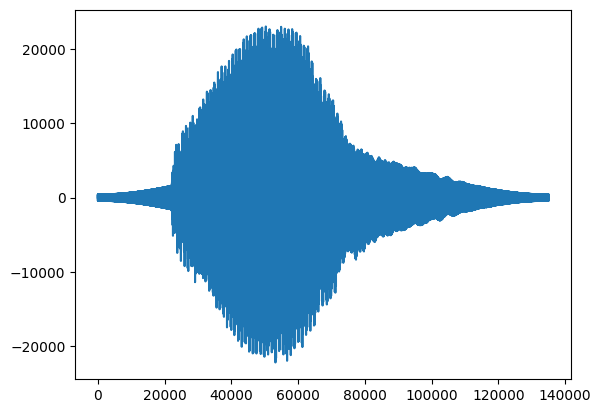

In [266]:
# Lecture du Basson
samplerate, data = read_wave("sounds/note_basson_plus_sinus_1000_Hz.wav")

# Appliquer une fenêtre de Hamming
basson_window = np.hamming(len(data)) * data 

# Affichage
plt.plot(basson_window)
plt.show()

# ***Affichage des spectres de fourier du basson (original) en dB avec l'axe des fr/quences en Hz***
# fft_original = np.fft.fft(data)
# original_db = 20 * np.log10(np.abs(fft_original)) 
# plt.title("Spectre de Fourier original")
# plt.plot()
# plt.show()


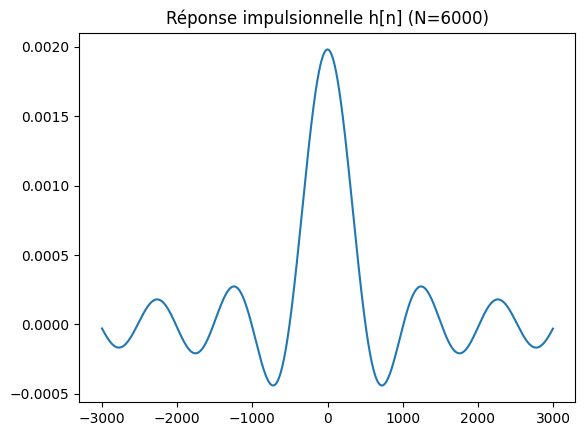

In [264]:
# Paramètres
N = 6000
fc_0 = 1000
fc_1 = 40
fe = samplerate 
n = np.arange(0 - (N / 2), (N / 2))
m = (N * fc_1) / fe
k = (2 * m) + 1

# Normalisation des fréquences
w_0 = (2 * np.pi * fc_0) / fe
w_1 = (2 * np.pi * fc_1) / fe

# Réponse impulsionnelle du filtre passe-bas
h_lp = [1 / N * (np.sin(math.pi * n[i] * k / N) / np.sin(math.pi * n[i] / N)) if n[i] != 0 else k/N for i in range(N)]

# FFT du filtre passe-bas et transformation en dB
hfft_pb = np.fft.fft(h_lp)
h_db = 20 * np.log10(np.abs(hfft_pb)) 

# Representation Graphique
plt.title(f"Réponse impulsionnelle h[n] (N={N})")
plt.plot(n, h_lp)
plt.show()

# plt.title(f"Amplitude (N={N})")
# plt.xlim(0, math.pi)
# plt.plot(w, h_db)
# plt.show()


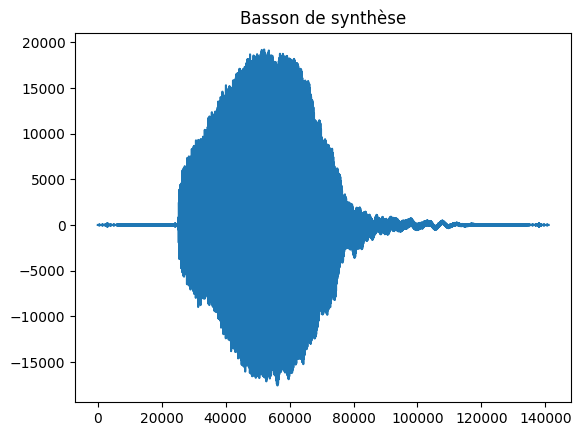

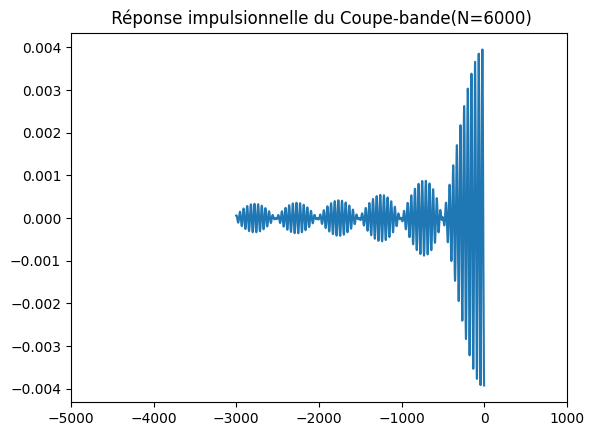

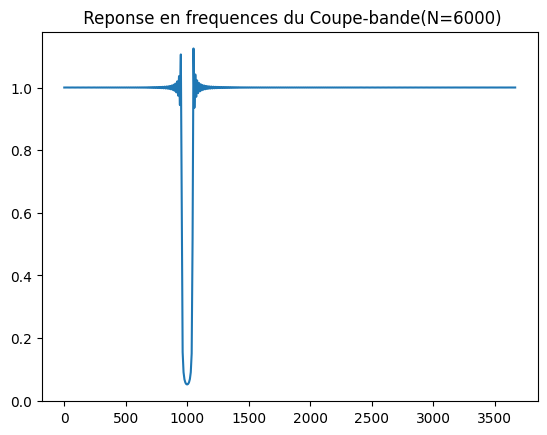

In [287]:
# Passe-bas -> Coupe-Bande
h_cb = []
for i in range(N):
    delta = 1 if(n[i] == 0) else 0
    h_cb.append(delta - np.multiply(2 * h_lp[i], np.cos(w_0 * n[i])))

# fft du coupe bande pour afficher la frequence coupé
cb_freq = np.fft.rfftfreq(len(h_cb), d=1./fe)
hfft_cb = np.fft.rfft(h_cb)

# Convolution du basson origine avec le filtre coupe-bande
basson_synthese = np.convolve(basson_window, h_cb)

# Création du nouveau basson
write(f"sounds/basson-synthese.wav", samplerate, basson_synthese.astype(np.int16))

# Affichage du basson de synthèse
plt.title("Basson de synthèse")
plt.plot(basson_synthese)
plt.show() 

# Graphique
plt.title(f" Réponse impulsionnelle du Coupe-bande(N={N})")
plt.plot(n,h_cb)
plt.xlim([-5000, 1000])
plt.show() 

plt.title(f" Reponse en frequences du Coupe-bande(N={N})")
plt.plot(cb_freq[:500], np.abs(hfft_cb[:500]))
plt.show() 

#amplitude et phase du coupe-bande
# amplitude_fft_spect_coupe_bande = np.abs(hfft_cb)
# phase_fft_spect_coupe_bande  = np.angle(hfft_cb)

# print(np.argmax(amplitude_fft_spect_coupe_bande))
# print(arr_freq[np.argmax(phase_fft_spect_coupe_bande)])

# plt.stem(cb_freq, phase_fft_spect_coupe_bande)
# plt.xlim(0, 200)
# plt.show()

# plt.stem(cb_freq, amplitude_fft_spect_coupe_bande)
# plt.xlim(900, 1500)
# plt.show()

Tests

In [ ]:
w = [(i * 2 * math.pi) / (N) for i in range(N)]
plt.yscale('log')
plt.plot(w, arr_amp_n)